# Financial Risk Management

### By Carlos Santillán

#### Start date: September 20, 2019
#### 2nd Date: April 15, 2020

This notebook is written with the purpose of becoming a repository of useful algorithms used in Financial Risk Management. The language chosen for this notebook is Python, everything will be developed using this language.

The ultimate purpose of this notebook is to become an Interactive Dashboard for Financial Risk Management.

## Table of Contents

To be written

## Import Block

In [3]:
import numpy as np                  # Vectores 
import pandas as pd                 # DataFrames 
import matplotlib.pyplot as plt     # Gráficas 
import math                         # Operaciones 
import seaborn as sns               # Gráficos y controles de Scrapping 
import random                       # Muestreos aleatorios 
import quandl                       # Datasets financieros 
import yahoo_finance                # Acceso a Yahoo Finanzas 
from scipy import stats             # Paquetería estadística 
from scipy.stats import kstest      # Prueba de Kolmogorov-Smirnov 
from scipy.stats import beta        # Distribución Beta 
from scipy.stats import expon       # Distribución Exponencial 
from scipy.stats import uniform     # Distribución uniforme 
from scipy.stats import norm        # Distribución normal 
from scipy.stats import binom       # Distribución Binomial 

### This part is a substitute of istalling directly from promt
import pip 
from pip._internal import main 
main(['install', 'pandas_datareader']) 
#main(['install', 'fix_yahoo_finance']) 
from pandas_datareader import data as web 
#import fix_yahoo_finance 

%matplotlib inline 

## 1. VaR - One Asset

### 1.1 Parametric VaR

For this 1st part, I´m going to calculate the **parametric VaR** as well as the **Empirical VaR** of a dataset obtained from Yahoo.
 

In this case, let us use **Swiss Re (SREN.SW)** stock price. 

We will also ask for the user to input the dates he wants to get data from:

In [4]:
def get_quote_data():
    '''
    User will be prompted for quote, start and end date for the price series.
    quote should be introduced as string
    Dates should have format yyyy-mm-dd
    Dates will be entered as string and then transformed into datetime type
    Column 'Adj Close' will be renamed to 'adj_close'
    Output: dataframe with quote's financial data in the selected date range
    '''
    quote = input("Please enter the quote of the company of your interest: ")
    start_Date = input("Please enter start date for price series (format should be yyyy-mm-dd): ")
    end_Date = input("Please enter end date for price series (format should be yyyy-mm-dd): ")
    
    start_Date_Datetime = pd.to_datetime(start_Date)     
    end_Date_Datetime = pd.to_datetime(end_Date)

    dataFrame = web.get_data_yahoo(quote, start_Date_Datetime, end_Date_Datetime)
    
    dataFrame.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
    
    print("You selected " + quote + " as the company you want to download data from")
    print("You selected " + start_Date + " as starting date")
    print("You selected " + end_Date + " as ending date")
    print("Here are the first 5 records of your data:")
    print(dataFrame.head())
    
    return dataFrame


In [5]:
df = get_quote_data()

Please enter the quote of the company of your interest: SREN.SW
Please enter start date for price series (format should be yyyy-mm-dd): 2019-04-24
Please enter end date for price series (format should be yyyy-mm-dd): 2020-04-24
You selected SREN.SW as the company you want to download data from
You selected 2019-04-24 as starting date
You selected 2020-04-24 as ending date
Here are the first 5 records of your data:
                 High        Low       Open      Close     Volume  adj_close
Date                                                                        
2019-04-24  98.800003  97.760002  97.980003  97.820000  2454474.0  90.486610
2019-04-25  98.480003  97.519997  97.720001  98.279999  1323717.0  90.912125
2019-04-26  98.400002  97.800003  98.279999  98.139999  1728084.0  90.782616
2019-04-29  98.440002  97.779999  98.019997  98.239998  1443031.0  90.875122
2019-04-30  98.559998  97.879997  98.120003  98.059998  1361519.0  90.708611


Now that we have our data, it would be useful to visualize 'Close' and 'Adj Close':

In [6]:
def plot_close(dataFrame):
    '''
    For any given dataframe, plot columns Close and adj_close
    Output: Plot of Close vs Adj Close
    '''
    plt.plot(dataFrame.index, df['Close'], '-r', label = 'Close')
    plt.plot(dataFrame.index, df['adj_close'], '-b', label = 'Adj Close')
    plt.legend(loc='upper left')
    plt.title("Adjusted Close vs. Close")

    return 


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


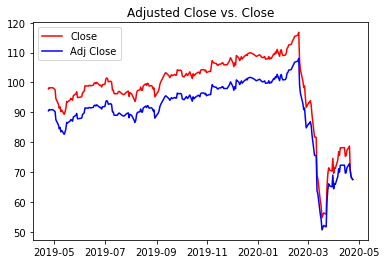

In [7]:
plot_close(df)

For our calculations, we will be using the **Adj Close** column. Using the Ajusted value at Close is convenient for the following reasons:

- Corporate matters (SPLIT)

- Dividends

- Decrease stock price in order to issu more stocks

- Decrease volume of stocks, hence increasing stock price

- It is calculated as the average of the last 3 hours

Now it's time to calculate our returns. This can be done in 2 different ways:

1. Simple returns
2. Logarithmic returns

What's the difference between them?

For instance, the formula for **Simple returns is as follows**

$$R_{t+1} = \frac{Price_{t+1}}{Price_{t}} -1 $$

and the formula for **Logarithmic returns** is as follows:

$$R_{t+1}ln = ln(\frac{Price_{t+1}}{Price_{t}}) $$


So, as you can see, Simple Returns is actually just looking at the difference in percentage between the two values, current and past price, whereas Logarithmic Returns gets the natural logarithm of the quotient of both.

For convenience we will calculate both, but for the rest of our calculations we will use Logarithmic Returns.

Why? Because returns calculated that way allow us to use properly the **Black-Scholes Formula**

Notice that in this format of dataframe, our 'Adj Close' column is always in the 6th position, hence we can make a reference to it using *.iloc[]* with the index 5 (since Python begins enumerating from 0)

In [8]:
def calculate_returns(dataFrame):
    '''
    Input: dataframe with financial data
    Column with Adj Close must be in the 6th position if it is to be referenced with .iloc
    Calculate simple returns of Adj Close
    Calculate logarithmic returns of Adj Close
    Output: dataframe with 2 additional columns
    '''
    
    ### Get adj_close as a Numpy array
    adj_Close_np = np.asarray(dataFrame['adj_close'])
    
    ### Construct return arrays, with dimension of adf_close -1
    simple_Returns = np.zeros(len(adj_Close_np) - 1)
    log_Returns = np.zeros(len(adj_Close_np) - 1)
    
    ### Calculate simple and log returns
    for i in range(len(adj_Close_np) - 1):
        simple_Returns[i] = (adj_Close_np[i+1] / adj_Close_np[i]) - 1
        log_Returns[i] = np.log(adj_Close_np[i+1] / adj_Close_np[i])
    
    ### Convert returns to Pandas Series
    simple_Returns_pd = pd.Series(simple_Returns)
    log_Returns_pd = pd.Series(log_Returns)
    
    ### For our columns to be included, we need both dataframes to have the same index
    ### so we will turn 'Date' into a column and then we´ll return it as index
    dataFrame.reset_index(inplace=True,drop=False)
    
    ### Duplicate Date column in order to have one as well as the index
    dataFrame['date_col'] = dataFrame['Date']
    
    ### Include return´s series in dataframe
    dataFrame['simple_returns'] = simple_Returns_pd
    dataFrame['log_returns'] = log_Returns_pd
    
    ### Shift returns columns 1 space below
    dataFrame['simple_returns'] = dataFrame['simple_returns'].shift(+1)
    dataFrame['log_returns'] = dataFrame['log_returns'].shift(+1)
    
    ### Return Date column to index
    dataFrame = dataFrame.set_index('Date')
    
    return dataFrame

In [9]:
df2 = calculate_returns(df)
df2.head()

,High,Low,Open,Close,Volume,adj_close,date_col,simple_returns,log_returns
Date,,,,,,,,,
2019-04-24,98.800003,97.760002,97.980003,97.820000,2454474.0,90.486610,2019-04-24,NaN,NaN
2019-04-25,98.480003,97.519997,97.720001,98.279999,1323717.0,90.912125,2019-04-25,0.004703,0.004691
2019-04-26,98.400002,97.800003,98.279999,98.139999,1728084.0,90.782616,2019-04-26,-0.001425,-0.001426
2019-04-29,98.440002,97.779999,98.019997,98.239998,1443031.0,90.875122,2019-04-29,0.001019,0.001018
2019-04-30,98.559998,97.879997,98.120003,98.059998,1361519.0,90.708611,2019-04-30,-0.001832,-0.001834


Now it would be useful to visualize the distribution of our returns:

In [10]:
def plot_returns_distribution(dataFrame):
    '''
    For a given Dataframe, plot the distribution of the log_returns
    Output: Plot of frequencies 
    '''
    returns = np.asarray(dataFrame['log_returns'])          ### turn column into numpy array
    returns = returns[np.logical_not(np.isnan(returns))]    ### remove NaN values from array
    
    sns.distplot(returns)
    plt.title("Distribution of Log Returns")
    
    return 

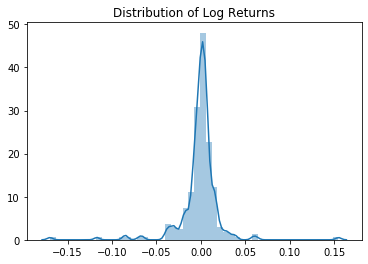

In [11]:
plot_returns_distribution(df2)

We can now proceed to calculate **Parametric VaR**.

For this, it will be necessary to calculate the mean $\mu$ and the standard deviation $\sigma$ of our log returns, as well as to prompt user for the value of the position taken:


In [26]:
def get_parametric_VaR(dataFrame):
    '''
    For a given dataframe, we will calculate the Parametric VaR
    Calculates mean of log returns
    Calculates standard deviation of log returns
    Prompts user for position value
    Calculates negative and positive VaR
    Quantiles considered will be 95%, 99.5% and 99.9%
    Output: table with mean, stdev, value position and VaR in negative and positive values
    '''
    
    ### Prompt user for position value
    position_Value = input("Enter value of position taken (no commas)")
    print("Position value is: " + position_Value)
    
    ### Covnert position value to float
    position_Value = float(position_Value)
    
    ### Calculate mean and stdev of log-returns
    mean_Returns = dataFrame['log_returns'].mean()
    stdev_Returns = dataFrame['log_returns'].std()
    
    ### Calculate inverse of normal distribution (quantile function)
    z_95 = norm.ppf(0.95)
    z_995 = norm.ppf(0.995)
    z_999 = norm.ppf(0.999)
    
    ### Calculate Negative VaR
    neg_VaR_95 = mean_Returns - (z_95 * stdev_Returns)
    neg_VaR_995 = mean_Returns - (z_995 * stdev_Returns)
    neg_VaR_999 = mean_Returns - (z_999 * stdev_Returns)
    
    ### Calculate Positive VaR
    pos_VaR_95 = mean_Returns + (z_95 * stdev_Returns)
    pos_VaR_995 = mean_Returns + (z_995 * stdev_Returns)
    pos_VaR_999 = mean_Returns + (z_999 * stdev_Returns)
    
    ### Calculate VaR in terms of Position Value
    neg_Value_VaR_95 = neg_VaR_95 * position_Value
    neg_Value_VaR_995 = neg_VaR_995 * position_Value
    neg_Value_VaR_999 = neg_VaR_999 * position_Value
    pos_Value_VaR_95 = pos_VaR_95 * position_Value
    pos_Value_VaR_995 = pos_VaR_995 * position_Value
    pos_Value_VaR_999 = pos_VaR_999 * position_Value
    
    ### Convert VaR into percentage
    neg_VaR_95 = neg_VaR_95 * 100
    neg_VaR_995 = neg_VaR_995 * 100
    neg_VaR_999 = neg_VaR_999 * 100
    pos_VaR_95 = pos_VaR_95 * 100
    pos_VaR_995 = pos_VaR_995 * 100
    pos_VaR_999 = pos_VaR_999 * 100
    
    ### Print mean and stdev
    print("The mean of our returns is: " + str(mean_Returns) + "\n")
    print("The stdev of our returns is: " + str(stdev_Returns) + "\n")
    
    ### Display VaR in 2 different dataframes, one for negative and the other for positive
    column_Names = ['95%', '99.5%', '99.9%']                     ### declare names for the columns 
    neg_index_Names = ['Zq', '-VaR(1-q)', '-VaR in Value']       ### row names for negative VaR
    pos_index_Names = ['Zq', '+VaR(1-q)', '+VaR in Value']       ### row names for positive VaR
    
    dfObj_Negative = pd.DataFrame(columns = column_Names, index = neg_index_Names)     ### empty dataframe
    dfObj_Positive = pd.DataFrame(columns = column_Names, index = pos_index_Names)     ### empty dataframe
    
    zq_list = [z_95, z_995, z_999]
    neg_VaR_list = [neg_VaR_95, neg_VaR_995, neg_VaR_999]
    neg_Value_list = [neg_Value_VaR_95, neg_Value_VaR_995, neg_Value_VaR_999]
    pos_VaR_list = [pos_VaR_95, pos_VaR_995, pos_VaR_999]
    pos_Value_list = [pos_Value_VaR_95, pos_Value_VaR_995, pos_Value_VaR_999]
    
    ### Append rows to empty dataframes
    dfObj_Negative.loc['Zq'] = zq_list
    dfObj_Negative.loc['-VaR(1-q)'] = neg_VaR_list
    dfObj_Negative.loc['-VaR in Value'] = neg_Value_list
    dfObj_Positive.loc['Zq'] = zq_list
    dfObj_Positive.loc['+VaR(1-q)'] = pos_VaR_list
    dfObj_Positive.loc['+VaR in Value'] = pos_Value_list
    
    print("PARAMETRIC VaR \n")
    print(dfObj_Negative)
    print(dfObj_Positive)
    
    return neg_VaR_list, pos_VaR_list
    

In [27]:
get_parametric_VaR(df2)

Enter value of position taken (no commas)1000000
Position value is: 1000000
The mean of our returns is: -0.0011734823243725885

The stdev of our returns is: 0.023212408783896233

PARAMETRIC VaR 

                   95%    99.5%    99.9%
Zq             1.64485  2.57583  3.09023
-VaR(1-q)     -3.93545 -6.09647 -7.29052
-VaR in Value -39354.5 -60964.7 -72905.2
                   95%    99.5%    99.9%
Zq             1.64485  2.57583  3.09023
+VaR(1-q)      3.70075  5.86177  7.05583
+VaR in Value  37007.5  58617.7  70558.3


([-3.935449710284452, -6.09646850758884, -7.290521785234224],
 [3.7007532454099343, 5.861772042714322, 7.055825320359707])

### 1.2 Empirical VaR

For contrasting purposes, it would be nice to also get our **Empirical VaR**:

In [28]:
def get_empirical_VaR(dataFrame):
    '''
    For a given dataframe, calculate Empirical VaR
    Calculate VaR for 95%, 99.5% and 99.9% confidence levels
    User will be prompted for position value
    '''
    ### Prompt user for position value
    position_Value = input("Enter value of position taken (no commas)")
    print("Position value is: " + position_Value)
    
    ### Covnert position value to float
    position_Value = float(position_Value)
    
    ### Get quantile of log returns
    neg_Empirical_VaR_95 = (dataFrame['log_returns'].quantile(1 - 0.95)) * 100
    neg_Empirical_VaR_995 = (dataFrame['log_returns'].quantile(1 - 0.995)) * 100
    neg_Empirical_VaR_999 = (dataFrame['log_returns'].quantile(1 - 0.999)) * 100
    pos_Empirical_VaR_95 = (dataFrame['log_returns'].quantile(0.95)) * 100
    pos_Empirical_VaR_995 = (dataFrame['log_returns'].quantile(0.995)) * 100
    pos_Empirical_VaR_999 = (dataFrame['log_returns'].quantile(0.999)) * 100
    
    ### Create lists of resulting VaR
    neg_Empirical_VaR_list = [neg_Empirical_VaR_95, neg_Empirical_VaR_995, neg_Empirical_VaR_999]
    pos_Empirical_VaR_list = [pos_Empirical_VaR_95, pos_Empirical_VaR_995, pos_Empirical_VaR_999]
    
    ### Generate VaR in terms of value
    neg_Value_95 = (neg_Empirical_VaR_95 * position_Value) / 100
    neg_Value_995 = (neg_Empirical_VaR_995 * position_Value) / 100
    neg_Value_999 = (neg_Empirical_VaR_999 * position_Value) / 100
    pos_Value_95 = (pos_Empirical_VaR_95 * position_Value) / 100
    pos_Value_995 = (pos_Empirical_VaR_995 * position_Value) / 100
    pos_Value_999 = (pos_Empirical_VaR_999 * position_Value) / 100
    
    ### Create list of resulting VaR in values
    neg_Value_list = [neg_Value_95, neg_Value_995, neg_Value_999]
    pos_Value_list = [pos_Value_95, pos_Value_995, pos_Value_999]
    
    ### Display VaR in 2 different dataframes, one for negative and the other for positive
    column_Names = ['95%', '99.5%', '99.9%']               ### declare names for the columns 
    neg_index_Names = ['-VaR(1-q)', '-VaR in Value']       ### row names for negative VaR
    pos_index_Names = ['+VaR(1-q)', '+VaR in Value']       ### row names for positive VaR
    
    dfObj_Negative = pd.DataFrame(columns = column_Names, index = neg_index_Names)     ### empty dataframe
    dfObj_Positive = pd.DataFrame(columns = column_Names, index = pos_index_Names)     ### empty dataframe
    
    ### Fill dataframes
    dfObj_Negative.loc['-VaR(1-q)'] = neg_Empirical_VaR_list
    dfObj_Negative.loc['-VaR in Value'] = neg_Value_list
    dfObj_Positive.loc['+VaR(1-q)'] = pos_Empirical_VaR_list
    dfObj_Positive.loc['+VaR in Value'] = pos_Value_list
    
    print("EMPIRICAL VaR \n")
    print(dfObj_Negative)
    print(dfObj_Positive)
    
    return neg_Empirical_VaR_list, pos_Empirical_VaR_list
    
    

In [29]:
get_empirical_VaR(df2)

Enter value of position taken (no commas)1000000
Position value is: 1000000
EMPIRICAL VaR 

                   95%    99.5%    99.9%
-VaR(1-q)     -3.08496 -10.9369 -15.6638
-VaR in Value -30849.6  -109369  -156638
                   95%    99.5%    99.9%
+VaR(1-q)      1.93148  6.15887  13.1787
+VaR in Value  19314.8  61588.7   131787


([-3.0849599314346525, -10.936924252100598, -15.663838634703856],
 [1.9314808702003996, 6.158865650670622, 13.178676687824845])

So what have we actually gotten?

Well, let's talk abut how shouldour calculations be interpreted. For instance, letus look at our **Parametric VaR** results, particularly at the value for 95% confidence in the row '-VaR(1-q)'.

We can observe the value $-3.88266$, let us also remember that we´re looking at daily data. So, we should interpret this as:

- With a confidence of 95% (i.e. with a probability of 5%) the worst scenario we can observe in a day (auming no intra-day trading) is that our stock looses $3.88266%$, 

- or in terms of the value of our position (in this case, $1,000,000$ CHF) we can loose up to $38,826$ CHF

### 1.3 Historical Simulation

We already have a dataframe with our log returns, let us take a brief look at it:

In [16]:
df2.head()

,High,Low,Open,Close,Volume,adj_close,date_col,simple_returns,log_returns
Date,,,,,,,,,
2019-04-24,98.800003,97.760002,97.980003,97.820000,2454474.0,90.486610,2019-04-24,NaN,NaN
2019-04-25,98.480003,97.519997,97.720001,98.279999,1323717.0,90.912125,2019-04-25,0.004703,0.004691
2019-04-26,98.400002,97.800003,98.279999,98.139999,1728084.0,90.782616,2019-04-26,-0.001425,-0.001426
2019-04-29,98.440002,97.779999,98.019997,98.239998,1443031.0,90.875122,2019-04-29,0.001019,0.001018
2019-04-30,98.559998,97.879997,98.120003,98.059998,1361519.0,90.708611,2019-04-30,-0.001832,-0.001834


The idea behind **Historical Simulation** is to take a base scenario (our las observed price is commonly used) and apply the corresponding log return rate to it, so our simulated prices follow the formula:

$$SimPrice_{t} = base (1 + log return_{t})$$

And for calculating the **Historical Simulation VaR**, we will need **simulated returns** calculated as follows:

$$SimReturn_{t} = ln(\frac{SimPrice_{t}}{base})$$

In the end, our VaR will be given by the desired percentile of out simulated returns vector.

In [51]:
def get_historical_VaR(dataFrame):
    '''
    For a given dataframe, calculate the historical simulated VaR
    Get base scenario as our last price observed in the series
    Simulate prices
    Simulate returns
    Calculate VaR for 95%, 99.5% and 99.9%
    Output: dataframe with VaR results
    '''
    ### Prompt user for position value
    position_Value = input("Enter value of position taken (no commas)")
    print("Position value is: " + position_Value)
    
    ### Covnert position value to float
    position_Value = float(position_Value)
    
    ### Get base scenario as our last observed value in adj_close
    base_Scenario = dataFrame['adj_close'].iloc[-1]
    
    ### Create arrays for simulated prices and simulated returns
    sim_Prices = np.zeros(len(dataFrame.index) - 1)
    sim_Returns = np.zeros(len(dataFrame.index) - 1)
    
    ### Transform log_returns column into Numpy array
    log_Returns_np = np.asarray(dataFrame['log_returns'])
    
    ### Remove NaN value from log_returns array
    log_Returns_np = log_Returns_np[np.logical_not(np.isnan(log_Returns_np))]
    
    ### Fill arrays of simulated prices and returns
    for i in range(len(log_Returns_np)):
        sim_Prices[i] = base_Scenario * (1 + log_Returns_np[i])
        sim_Returns[i] = np.log(sim_Prices[i] / base_Scenario)
    
    ### Calculate VaR
    hist_VaR_95 = np.quantile(sim_Returns, 1 - 0.95)
    hist_VaR_995 = np.quantile(sim_Returns, 1 - 0.995)
    hist_VaR_999 = np.quantile(sim_Returns, 1 - 0.999)
    
    ### Calculate VaR in terms of value position
    hist_VaR_Value_95 = hist_VaR_95 * position_Value
    hist_VaR_Value_995 = hist_VaR_995 * position_Value
    hist_VaR_Value_999 = hist_VaR_999 * position_Value
    
    ### VaR in percentage (for print purposes)
    hist_VaR_95_pct = hist_VaR_95 * 100
    hist_VaR_995_pct = hist_VaR_995 * 100
    hist_VaR_999_pct = hist_VaR_999 * 100
    
    ### Create list of resulting VaR (this is our output)
    hist_VaR_list = [hist_VaR_95, hist_VaR_995, hist_VaR_999]
    
    ### Create list of VaR in percentage (for print purposes)
    hist_VaR_pct_list = [hist_VaR_95_pct, hist_VaR_995_pct, hist_VaR_999_pct]
    
    ### Create list of VaR in terms of value
    hist_VaR_Value_list = [hist_VaR_Value_95, hist_VaR_Value_995, hist_VaR_Value_999]
    
    ### Display VaR in 2 different dataframes, one for negative and the other for positive
    column_Names = ['95%', '99.5%', '99.9%']               ### declare names for the columns 
    neg_index_Names = ['-VaR(1-q)', '-VaR in Value']       ### row names for negative VaR
    
    dfObj_Negative = pd.DataFrame(columns = column_Names, index = neg_index_Names)     ### empty dataframe
    
    ### Fill dataframes
    dfObj_Negative.loc['-VaR(1-q)'] = hist_VaR_pct_list
    dfObj_Negative.loc['-VaR in Value'] = hist_VaR_Value_list
    
    print("HISTORICAL SIMULATION VaR \n")
    print(dfObj_Negative)
    
    ### Plot distribution of Simulated Returns
    sns.distplot(sim_Returns)
    plt.title("Historical Simulated Returns Distribution")
    
    
    #base_Vector = np.repeat(base_Scenario, len(sim_Prices))
    #plt.plot(sim_Prices)
    #plt.plot(base_Vector)
    
    return hist_VaR_list

Enter value of position taken (no commas)1000000
Position value is: 1000000
HISTORICAL SIMULATION VaR 

                   95%   99.5%    99.9%
-VaR(1-q)     -3.13355 -11.594 -17.0717
-VaR in Value -31335.5 -115940  -170717


[-0.03133548758846658, -0.11593953385281977, -0.1707168374834182]

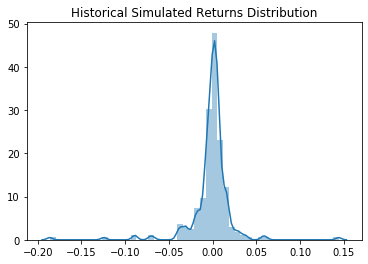

In [52]:
get_historical_VaR(df2)

So, for this example we can observe that at 95% of confidence, the highest VaR is the paremetric one, with the historical being second and empirical 3rd.

We can also observe that this ranking actually reverses when looking at the 99.9% confidence values.

Why does this happen?

When is it appropiate to use each method?

### 1.4 Monte Carlo Simulation

Monte-Carlo simulations of returns consists on:

1. taking a base scenario (which can be the last observed value of the series i.e. the most actual) 


2. Calculating $\mu$ and $\sigma$ of out log returns


3. Defining a factor (which can be deafaulted to 1)


4. Defining the numer of periods we want to simulate


5. Simulate scenarios


6. Calculating our returns as $ln(\frac{p_{tn}}{p_{t0}})$


7. Finally, VaR can be calculated as the desired percentile of our returns


Our simulations should follow this formula:

$$t_{n} = t_{n-1} e^{Z}$$ where

$$ Z = (\mu - \frac{1}{2} \sigma^{2}) f + \sigma \Phi^{-1}(U)$$

with $f$ being our factor and $U$ being a random number $U(0, 1)$.



In [151]:
def ov_get_monte_carlo_VaR(dataFrame):
    '''
    INPUT: dataframe with financial data
    
    DESC.: Calculate Monte-Carlo VaR for levels 95%, 99.5%, 99.9%
    
    Get base scenario as las observed value in adj_close
    Calculate mean and stdev of log_returns
    Prompt user for value position
    Prompt user for factor
    Prompt user for number of scenarios
    Simulate scenarios
    Calculate returns
    Calculate VaR
    
    OUTPUT: array with Monte-Carlo VaR
    OUTPUT: array with returns via Monte Carlo
    OUTPUT: matrix A with simulated scenarios
    '''
    ### Get base scenario
    base_Scenario = df2['adj_close'].iloc[-1]
    
    ### Calculate mean and stdev
    mean = df2['log_returns'].mean()
    stdev = df2['log_returns'].std()
    
    ### Prompt user for data
    value_Position = input("Enter position of value taken: ")
    factor = input("Enter desired factor: ")
    m = input("Enter number of wanted scenarios (tn): ")
    n = input("Enter number of simulations: ")
    
    ### Confirm data chosen to user
    print("The value of the position is: " + value_Position)
    print("The chosen factor is: " + factor)
    print("The number of simulated scenarios is: " + m)
    print("The number of simulations is: " + n + "\n")
    
    ### Turn strings inputed into floats for calculation purposes
    value_Position = float(value_Position)
    factor = float(factor)
    m = int(m)
    n = int(n)
    
    ### Declare shape of simulations matrix
    shape_A = (m+1, n)     ### m+1 since we´re including the base vector
    
    ### Declare shape of Z matrix
    shape_Z = (m, n)      ### since we´re only using Z for the simulations and not the base vector
    
    ### Declare matrix for scenarios and simulations
    A = np.zeros(shape_A)
    
    ### Declare matrix for Z values
    Z = np.zeros(shape_Z)
    
    ### Declare array with replicated base scenario value
    base_Vector = np.repeat(base_Scenario, n)
    
    ### Assign base vector to first row of A
    A[0] = base_Vector
    
    ### Calculate Z matrix according to formula and simulated scenarios in matrix A
    for i in range(m):
        for j in range(n):
            Z[i][j] = ((mean - 0.5*(stdev**2)) * factor) + (stdev * norm.ppf(np.random.uniform(0, 1)))
            A[i+1][j] = A[i][j] * np.exp(Z[i][j])
    
    ### As confirmation, print number of rows and cols from matrix A once simulation is done:
    print("Simulation done" + "\n")
    print("Number of scenarios simulated: ", len(A)-1)
    print("Number of simulations made: ", len(A[0]))
    
    ### Calculate returns based on formula
    returns = np.zeros(n)
    returns = np.log(A[-1] / A[0])     ### output
    
    ### Calculate VaR
    mc_VaR_95 = np.quantile(returns, 1 - 0.95)
    mc_VaR_995 = np.quantile(returns, 1 - 0.995)
    mc_VaR_999 = np.quantile(returns, 1 - 0.999)
    
    ### Calculate VaR in terms of value position
    mc_VaR_Value_95 = mc_VaR_95 * value_Position
    mc_VaR_Value_995 = mc_VaR_995 * value_Position
    mc_VaR_Value_999 = mc_VaR_999 * value_Position
    
    ### VaR in percentage (for print purposes)
    mc_VaR_95_pct = mc_VaR_95 * 100
    mc_VaR_995_pct = mc_VaR_995 * 100
    mc_VaR_999_pct = mc_VaR_999 * 100
    
    ### Create list of resulting VaR (this is our output)
    mc_VaR_list = [mc_VaR_95, mc_VaR_995, mc_VaR_999]
    
    ### Create list of VaR in percentage (for print purposes)
    mc_VaR_pct_list = [mc_VaR_95_pct, mc_VaR_995_pct, mc_VaR_999_pct]
    
    ### Create list of VaR in terms of value
    mc_VaR_Value_list = [mc_VaR_Value_95, mc_VaR_Value_995, mc_VaR_Value_999]
    
    ### Display VaR in dataframe
    column_Names = ['95%', '99.5%', '99.9%']               ### declare names for the columns 
    neg_index_Names = ['-VaR(1-q)', '-VaR in Value']       ### row names for negative VaR
    
    dfObj_Negative = pd.DataFrame(columns = column_Names, index = neg_index_Names)     ### empty dataframe
    
    ### Fill dataframes
    dfObj_Negative.loc['-VaR(1-q)'] = mc_VaR_pct_list
    dfObj_Negative.loc['-VaR in Value'] = mc_VaR_Value_list
    
    print("Monte Carlo Simulation VaR \n")
    print(dfObj_Negative)
    
    return mc_VaR_list, returns, A
    

We assign the outputs of our one asset Monte Carlo function to the variables:

- mc_VaR

- mc_returns

- mc_A

In [152]:
mc_VaR, mc_returns, mc_A = ov_get_monte_carlo_VaR(df2)

Enter position of value taken: 1000000
Enter desired factor: 1
Enter number of wanted scenarios (tn): 5
Enter number of simulations: 1000
The value of the position is: 1000000
The chosen factor is: 1
The number of simulated scenarios is: 5
The number of simulations is: 1000

Simulation done

Number of scenarios simulated:  5
Number of simulations made:  1000
Monte Carlo Simulation VaR 

                   95%    99.5%    99.9%
-VaR(1-q)     -9.63009 -13.6284 -15.5442
-VaR in Value -96300.9  -136284  -155442


One cool feature is that we can actually visualize the simulated paths:

In [153]:
def one_asset_Monte_Carlo_paths(matrix):
    '''
    DESC.: Takes a given matrix and plots simulated paths together with the mean
    
    INPUT: matrix with simulated paths
    
    - Calculate mean path of given paths
    - Plot paths together with mean
    
    OUTPUT: plot with colors according to relative position w/ the mean
    '''
    mean_Paths = np.zeros(len(matrix))
    
    for i in range(len(matrix)):
        mean_Paths[i] = np.mean(matrix[i, :])
        
    plt.plot(matrix)
    plt.plot(mean_Paths, color = 'lime', linestyle = 'dashed', linewidth = 4.5)
    plt.title("Simulated Paths")
    
    return mean_Paths

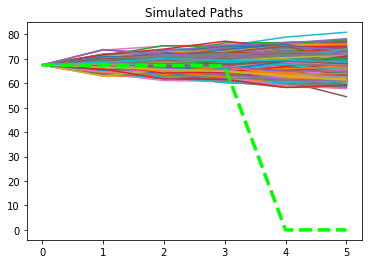

In [154]:
one_asset_Monte_Carlo_paths(mc_A)

In [87]:
n = 5
m = 10

A = np.zeros((n, m))

A[0][0]

for i in range(n):
    for j in range(m):
        A[i][j] = i
        
A[0][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [88]:
A

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])

In [89]:
base = df2['adj_close'].iloc[-1]
base

67.4800033569336

In [90]:
vector_base = np.repeat(base, 10)
vector_base

array([67.48000336, 67.48000336, 67.48000336, 67.48000336, 67.48000336,
       67.48000336, 67.48000336, 67.48000336, 67.48000336, 67.48000336])

In [92]:
vector_1 = np.zeros(len(vector_base))

In [94]:
Z = np.zeros(len(vector_base))

for i in range(len(Z)):
    Z[i] = ((media - 0.5*(stdev**2)) * factor) + (stdev * norm.ppf(np.random.uniform(0, 1)))
    
vector_1 = vector_base * np.exp(Z)
vector_1


array([68.09634193, 64.44574142, 68.74553968, 68.00290479, 66.92827068,
       67.45126542, 66.41710556, 67.57571374, 69.18184912, 67.79891788])

In [101]:
m = 4
n = 10

### Matrix de m x n
forma_A = (m, n)

### matriz A de forma m xn
A = np.zeros(forma_A)

A[0] = vector_base

A

array([[67.48000336, 67.48000336, 67.48000336, 67.48000336, 67.48000336,
        67.48000336, 67.48000336, 67.48000336, 67.48000336, 67.48000336],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [103]:
forma_Z = (m-1, n)

Z = np.zeros(forma_Z)

for i in range(m-1):
    for j in range(n):
        Z[i][j] = ((media - 0.5*(stdev**2)) * factor) + (stdev * norm.ppf(np.random.uniform(0, 1)))
        
Z

array([[-0.0069293 , -0.0186274 ,  0.00603026, -0.03095339, -0.00194993,
         0.02396748, -0.00604338, -0.01655959,  0.00232096, -0.01237245],
       [ 0.03491683,  0.01130671, -0.00224485,  0.04375639,  0.03706421,
         0.0092543 ,  0.01160712, -0.04079883,  0.022677  , -0.01330632],
       [-0.01365544, -0.01084184, -0.01178931,  0.02798866,  0.02294412,
        -0.00086714,  0.00030033, -0.01501163,  0.01449694,  0.01370467]])

In [105]:
for i in range(m-1):
    for j in range(n):
        A[i+1][j] = A[i][j] * np.exp(Z[i][j])

A

array([[67.48000336, 67.48000336, 67.48000336, 67.48000336, 67.48000336,
        67.48000336, 67.48000336, 67.48000336, 67.48000336, 67.48000336],
       [67.01403071, 66.23466115, 67.88815471, 65.42326455, 67.34855009,
        69.11686671, 67.07342557, 66.37176335, 67.63680376, 66.65025366],
       [69.39527911, 66.98780688, 67.73592679, 68.34950447, 69.89160783,
        69.75946359, 67.85649061, 63.71836856, 69.18812671, 65.76925814],
       [68.45409654, 66.26545873, 66.94205566, 70.28953864, 71.51374768,
        69.6989987 , 67.87687302, 62.76899573, 70.1984487 , 66.67680897]])

In [109]:
print("Número de renglones de A: ", len(A))
print("Número de columnas de A: ", len(A[0]))

Número de renglones de A:  4
Número de columnas de A:  10


In [110]:
rt = np.zeros(n)
rt

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [115]:
rt = np.log(A[-1] / A[0])
rt

array([ 0.01433209, -0.01816253, -0.0080039 ,  0.04079167,  0.0580584 ,
        0.03235464,  0.00586407, -0.07237005,  0.03949491, -0.01197411])

In [128]:
medias_simuladas = np.zeros(m)

for i in range(m):
    medias_simuladas[i] = np.mean(A[i, :])

medias_simuladas

array([67.48000336, 67.07577743, 67.86518327, 68.06850224])

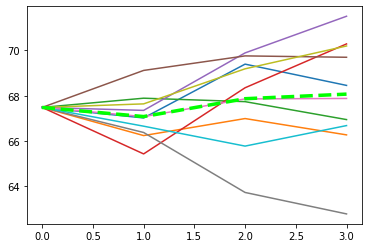

In [138]:
plt.plot(A)
plt.plot(medias_simuladas, color = 'lime', linestyle = 'dashed', linewidth = 3.5)

In [144]:
def f_1(x):
    A = np.zeros((2,2))
    res = x**2
    
    return A, res

x = np.linspace(0, 10, 11)

matriz, vector = f_1(x)

vector

array([  0.,   1.,   4.,   9.,  16.,  25.,  36.,  49.,  64.,  81., 100.])

# Parte correspondiente al curso, última update el 20/09/2019

## Bloque inicial

In [3]:
import numpy as np                  # Vectores
import pandas as pd                 # DataFrames
import matplotlib.pyplot as plt     # Gráficas
import math                         # Operaciones
from scipy import stats             # Paquetería estadística
from scipy.stats import kstest      # Prueba de Kolmogorov-Smirnov
from scipy.stats import beta        # Distribución Beta
from scipy.stats import expon       # Distribución Exponencial
from scipy.stats import norm        # Distribución Normal

%matplotlib inline   

- Consideraremos valores diarios, así que declaramos vectores de 365

In [22]:
### LLenamos vector con valores tomados de la Normal Inversa (0, 1)
mu = 0.005     ### mu de Black-Scholes
sigma = 0.02   ### sigma de Black-Scholes
n = 365        ### tamaño del vector
S0 = 40        ### Precio inicial

Nt = np.zeros(n)
Wt = np.zeros(n)

for i in range(0, len(Nt)-1):
    Nt[i] = np.random.uniform(0,1)

Wt = norm.ppf(Nt)

2. Construimos vector de valores acumulados (trayectoria) de $W_{t}$


In [15]:
trayWt = np.zeros(n)
trayWt[0] = Wt[0]
for i in range(0, len(trayWt)-1):
    trayWt[i+1] = trayWt[i] + Wt[i+1] 


3. Construimos el vector de $\mu + \sigma W_{t}$

In [19]:
muSigmaWt = np.zeros(n)
for i in range(0, len(muSigmaWt)-1):
    muSigmaWt[i] = mu + sigma*Wt[i]


4. Construimos trayectorias de $\mu + \sigma W_{t}$

In [21]:
trayMuSigmaWt = np.zeros(n)
trayMuSigmaWt[0] = muSigmaWt[0]
for i in range(0, len(trayMuSigmaWt)-1):
    trayMuSigmaWt[i+1] = trayMuSigmaWt[i] + muSigmaWt[i+1]